In [1]:
# Install if needed: pip install ucimlrepo pandas scikit-learn matplotlib seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [2]:
# Cell 2: Load YOUR ProDigy CSV file
df = pd.read_csv('bank.csv', sep=';')  # ← Use semicolon separator!

print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nColumns:", df.columns.tolist())
print("\n✅ ProDigy dataset loaded successfully!")


Dataset shape: (4521, 17)

First 5 rows:
   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no  

Columns: ['age', 'job', 'marital', 'education', 'default', 'balance',

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB
None

Target Distribution:
y
no     0.88476
yes    0.11524
Name: proportion, dtype: f

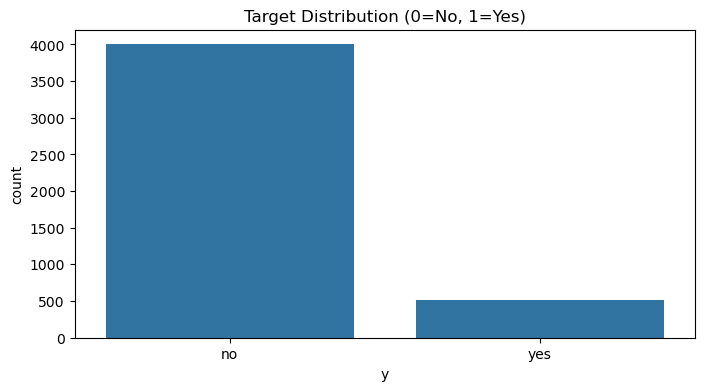


✅ EDA Complete - Dataset is imbalanced (88% No, 12% Yes)


In [3]:
print("Dataset Info:")
print(df.info())
print("\nTarget Distribution:")
print(df['y'].value_counts(normalize=True))

# Visualize target
plt.figure(figsize=(8, 4))
sns.countplot(x='y', data=df)
plt.title('Target Distribution (0=No, 1=Yes)')
plt.show()

print("\n✅ EDA Complete - Dataset is imbalanced (88% No, 12% Yes)")


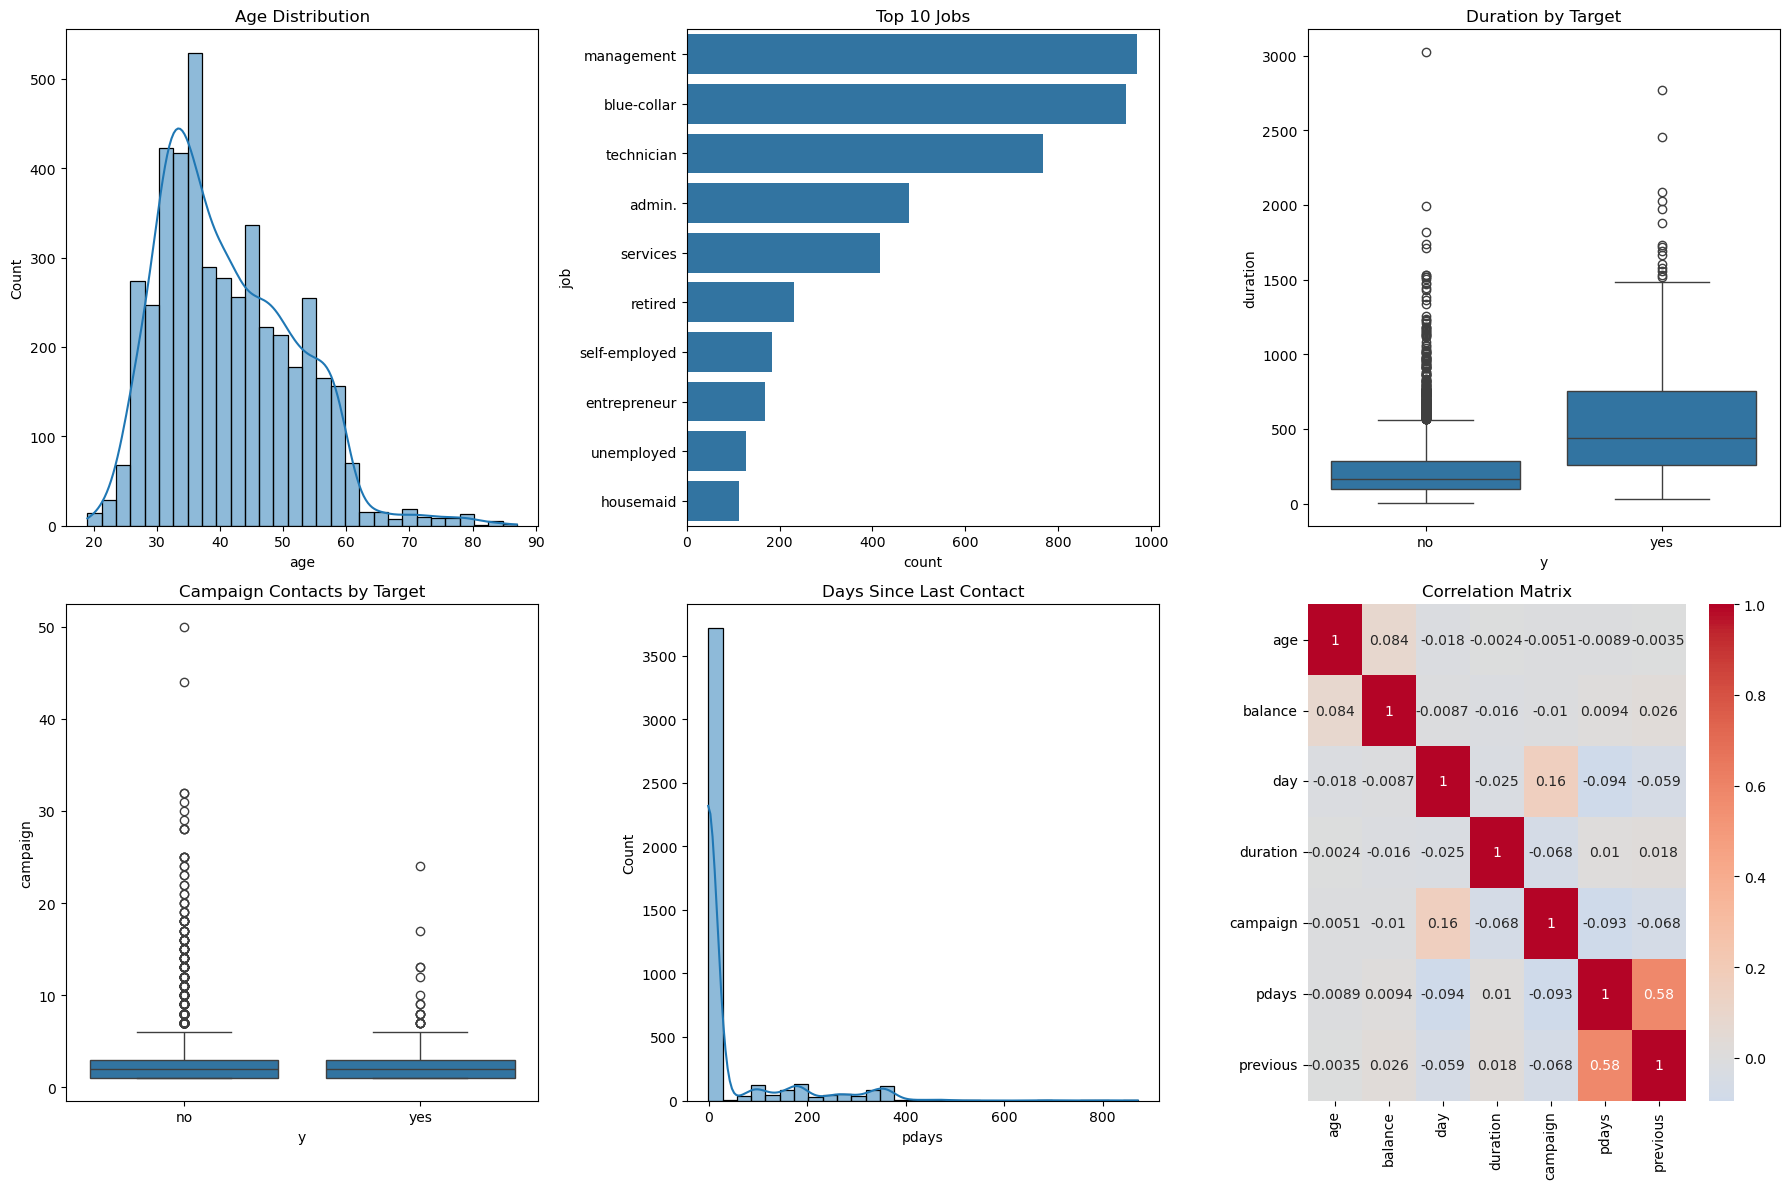

In [4]:
# Key feature distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Age distribution
sns.histplot(df['age'], bins=30, ax=axes[0,0], kde=True)
axes[0,0].set_title('Age Distribution')

# Job distribution
sns.countplot(y='job', data=df, ax=axes[0,1], order=df['job'].value_counts().index[:10])
axes[0,1].set_title('Top 10 Jobs')

# Duration vs Target
sns.boxplot(x='y', y='duration', data=df, ax=axes[0,2])
axes[0,2].set_title('Duration by Target')

# Campaign vs Target
sns.boxplot(x='y', y='campaign', data=df, ax=axes[1,0])
axes[1,0].set_title('Campaign Contacts by Target')

# Pdays distribution
sns.histplot(df['pdays'], bins=30, ax=axes[1,1], kde=True)
axes[1,1].set_title('Days Since Last Contact')

# Correlation heatmap (numeric only)
numeric_cols = df.select_dtypes(include=[np.number]).columns
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0, ax=axes[1,2])
axes[1,2].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()


In [5]:
# Create a copy for preprocessing
df_processed = df.copy()

# ✅ CORRECTED: Check actual column names first
print("Available columns:", df_processed.columns.tolist())
print("\nCategorical columns in dataset:")
print([col for col in df_processed.columns if df_processed[col].dtype == 'object'])

# Handle categorical variables with LabelEncoder - CORRECTED LIST
label_encoders = {}
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                   'contact', 'month', 'day', 'poutcome']  # ✅ 'day' not 'day_of_week'

# Only encode columns that exist
existing_cat_cols = [col for col in categorical_cols if col in df_processed.columns]

for col in existing_cat_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le

# Encode target variable
df_processed['y'] = df_processed['y'].map({'no': 0, 'yes': 1})

# Handle outliers in duration (optional but recommended)
Q1 = df_processed['duration'].quantile(0.25)
Q3 = df_processed['duration'].quantile(0.75)
IQR = Q3 - Q1
df_processed = df_processed[(df_processed['duration'] >= Q1 - 1.5*IQR) & 
                          (df_processed['duration'] <= Q3 + 1.5*IQR)]

print(f"\n✅ Preprocessing complete!")
print("Processed dataset shape:", df_processed.shape)
print("Categorical columns encoded:", len(existing_cat_cols))


Available columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

Categorical columns in dataset:
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

✅ Preprocessing complete!
Processed dataset shape: (4191, 17)
Categorical columns encoded: 10


In [6]:
# Features and target
X = df_processed.drop('y', axis=1)
y = df_processed['y']

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")


Training set: (3352, 16)
Test set: (839, 16)
Training target distribution:
y
0    0.914976
1    0.085024
Name: proportion, dtype: float64


In [7]:
# Initialize and train Decision Tree
dt_classifier = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

dt_classifier.fit(X_train, y_train)

# Basic predictions
y_train_pred = dt_classifier.predict(X_train)
y_test_pred = dt_classifier.predict(X_test)

print("✅ Model trained successfully!")


✅ Model trained successfully!


📊 Model Performance:
Training Accuracy: 0.9365
Test Accuracy: 0.9190
ROC-AUC Score: 0.8055

📈 Classification Report:
              precision    recall  f1-score   support

 No Purchase       0.94      0.97      0.96       768
    Purchase       0.53      0.32      0.40        71

    accuracy                           0.92       839
   macro avg       0.74      0.65      0.68       839
weighted avg       0.91      0.92      0.91       839



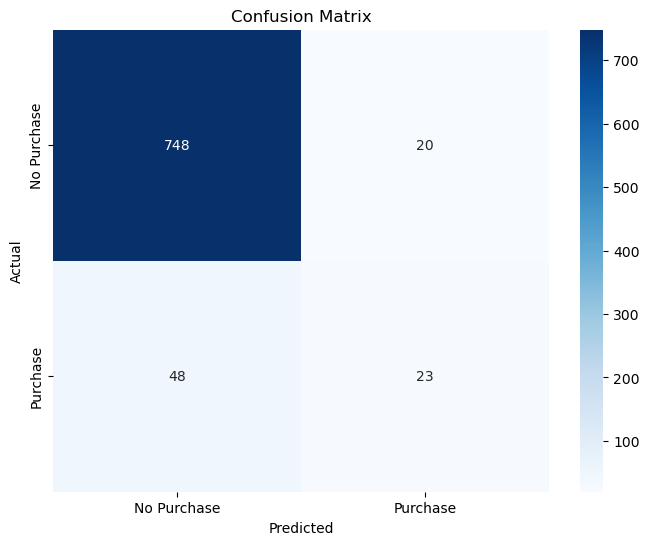

In [8]:
# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, dt_classifier.predict_proba(X_test)[:, 1])

print("📊 Model Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Detailed classification report
print("\n📈 Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['No Purchase', 'Purchase']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Purchase', 'Purchase'],
            yticklabels=['No Purchase', 'Purchase'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


🔍 Top 10 Most Important Features:
      feature  importance
11   duration    0.250542
13      pdays    0.214873
15   poutcome    0.160705
10      month    0.112924
0         age    0.082118
9         day    0.039320
3   education    0.036448
5     balance    0.035729
6     housing    0.033265
8     contact    0.016170


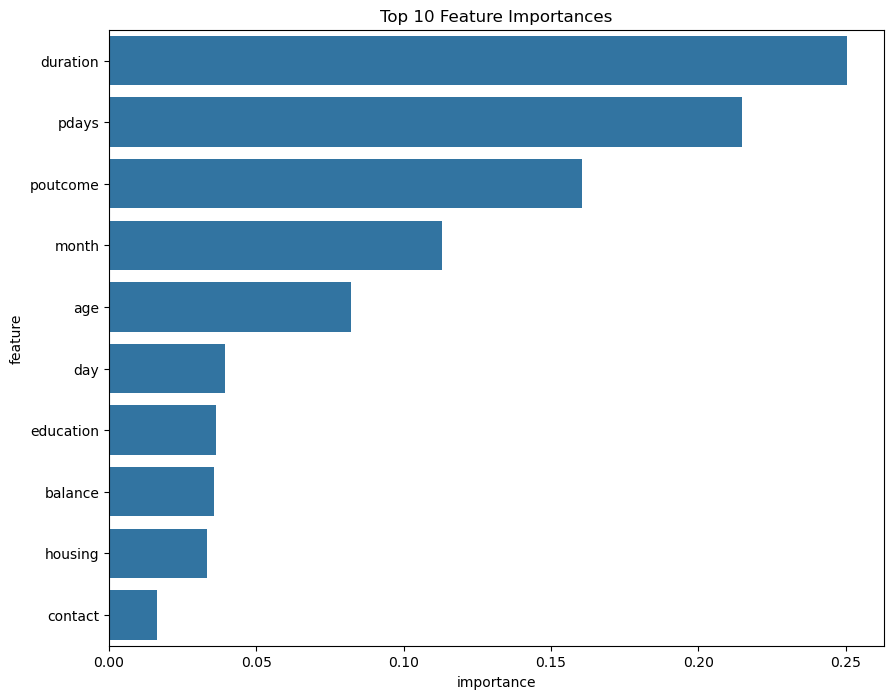

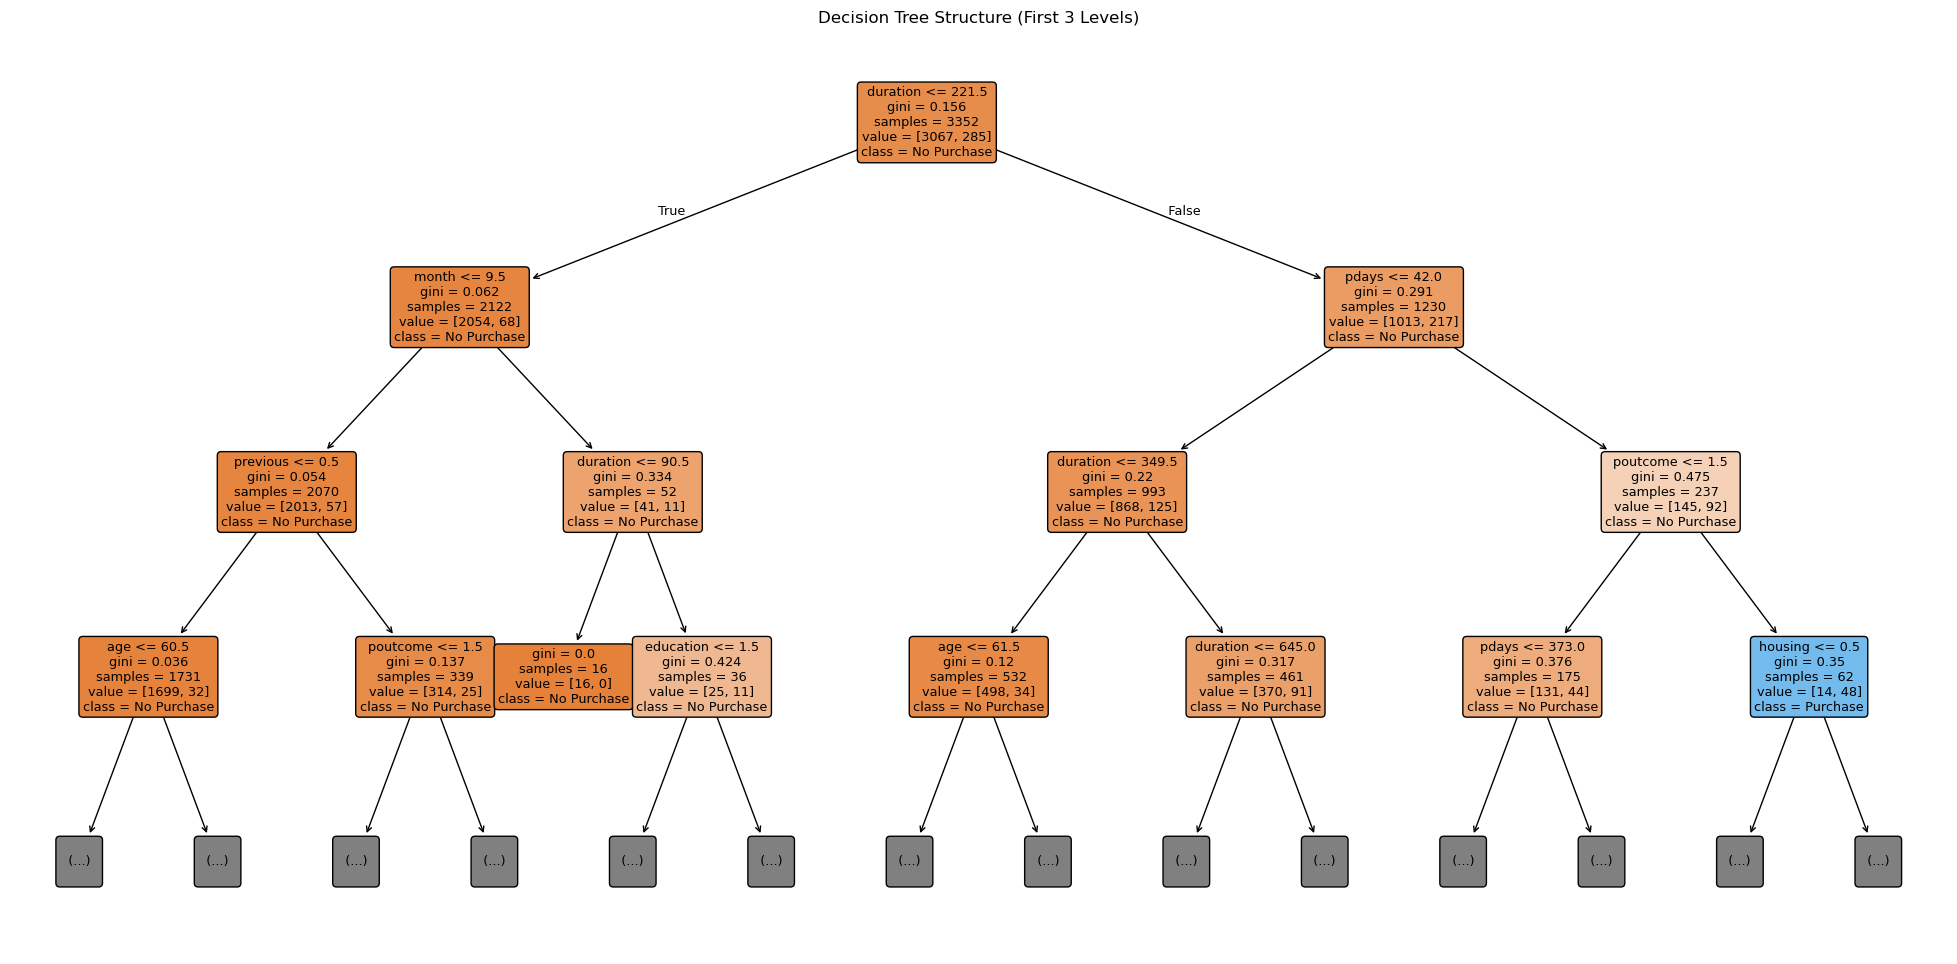

In [9]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("🔍 Top 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importances')
plt.show()

# Visualize decision tree (first 3 levels)
plt.figure(figsize=(25, 12))
plot_tree(dt_classifier, 
          max_depth=3,
          feature_names=X.columns,
          class_names=['No Purchase', 'Purchase'],
          filled=True,
          rounded=True)
plt.title('Decision Tree Structure (First 3 Levels)')
plt.show()
